# Taller E-Commerce - Juan Sebastian Angel Perez

## Importar bibliotecas

In [5]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento y Pipelines
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Métricas
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, accuracy_score, f1_score, roc_auc_score

# Configuraciones
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

## Carga y Preparación de Datos (E-Commerce 2008)

In [6]:
# Cargar datos de e-commerce
path = "data/e-shop clothing 2008.csv"
df = pd.read_csv(path, sep=";")

# --- Limpieza de datos básica ---
# Estandarización de nombres de columnas
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace('(', '')
    .str.replace(')', '')
)

# Transformar la columna page_2_clothing_model en variable categórica
df['page_2_clothing_model'] = df['page_2_clothing_model'].astype('category')

# Unificación de year, month, day en una sola columna de fecha
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


## Paso 1: Feature Engineering y Creación del Target

### Definir el Target (y) y Evitar Data Leakage:

In [7]:
# Crear la variable objetivo (Visited_Sale_Page)

visited_sale = (
    df.groupby('session_id')['page_1_main_category']
    .apply(lambda x: 1 if 4 in x.values else 0)
    .reset_index(name='Visited_Sale_Page')
)

# Evitar Data Leakage

df_filtered = df[df['page_1_main_category'] != 4]



### Crear las Features (X) y Agregar a Nivel de Sesión

In [8]:
# 1. Crear features agregadas a nivel sesión

session_features = (
    df_filtered
    .groupby('session_id')
    .agg(
        total_clicks=('order', 'count'),
        max_price_seen=('price', 'max'),
        avg_price_seen=('price', 'mean'),
        countries=('country', 'nunique'),
        distinct_products=('page_2_clothing_model', 'nunique'),
        main_category_mode=('page_1_main_category', lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    )
    .reset_index()
)

# 2. Crear el dataset final a nivel sesión uniendo features + target

df_sesiones = session_features.merge(visited_sale, on='session_id', how='left')

df_sesiones.head()

,session_id,total_clicks,max_price_seen,avg_price_seen,countries,distinct_products,main_category_mode,Visited_Sale_Page
0,1,7,57,41.857143,1,7,2,1
1,2,7,67,53.000000,1,5,2,1
2,3,5,48,42.000000,1,5,3,1
3,4,4,62,45.250000,1,4,1,0
4,5,1,57,57.000000,1,1,3,0


### ¡Pregunta Clave! Ya que tienes tu dataset final... ¿Cómo es la distribución de `Visited_Sale_Page`? ¿Es un problema balanceado o desbalanceado?

De a cuerdo a los reultados de *df_sesiones['Visited_Sale_Page'].value_counts(normalize=True) * 100* los datos están moderadamente desbalanceados.

In [9]:
df_sesiones['Visited_Sale_Page'].value_counts(normalize=True) * 100

Visited_Sale_Page
0    66.567941
1    33.432059
Name: proportion, dtype: float64

## Paso 2: El Pipeline de Preprocesamiento

In [10]:
# 1. Definir X e y
X = df_sesiones.drop(columns=['Visited_Sale_Page', 'session_id'])
y = df_sesiones['Visited_Sale_Page']

# 2. Listas de variables numéricas y categóricas
numeric_features = [
    'total_clicks',
    'max_price_seen',
    'avg_price_seen',
    'countries',
    'distinct_products'
]

categorical_features = [
    'main_category_mode'
]

# 3. Transformador para variables numéricas:
#    - Imputación (media)
#    - Escalado (StandardScaler)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# 4. Transformador para variables categóricas:
#    - Imputación (valor más frecuente)
#    - OneHotEncoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 5. ColumnTransformer que aplica cada bloque a sus columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


## Paso 3: "Jugando" con los Modelos

### Modelo 1 (Línea Base 1): `LogisticRegression`.

In [11]:
# 1. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 2. Pipeline con preprocessor + modelo
logreg_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# 3. Entrenar
logreg_model.fit(X_train, y_train)

# 4. Predicciones
y_pred = logreg_model.predict(X_test)
y_prob = logreg_model.predict_proba(X_test)[:, 1]

# 5. Resultados
logreg_results = {
    'accuracy': accuracy_score(y_test, y_pred),
    'f1': f1_score(y_test, y_pred, pos_label=1),
    'roc_auc': roc_auc_score(y_test, y_prob),
    'precision': precision_score(y_test, y_pred, pos_label=1),
    'recall': recall_score(y_test, y_pred, pos_label=1)
}

logreg_results

{'accuracy': 0.6784325456177086,
 'f1': 0.22382671480144403,
 'roc_auc': 0.6539236337811125,
 'precision': 0.5794392523364486,
 'recall': 0.13870246085011187}

### Modelo 2 (Línea Base 2): `DecisionTreeClassifier`

In [12]:
tree_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        random_state=42
    ))
])

# Entrenar
tree_model.fit(X_train, y_train)

# Predicciones
y_pred_tree = tree_model.predict(X_test)
y_prob_tree = tree_model.predict_proba(X_test)[:, 1]

# Métricas
tree_results = {
    'accuracy': accuracy_score(y_test, y_pred_tree),
    'f1': f1_score(y_test, y_pred_tree, pos_label=1),
    'roc_auc': roc_auc_score(y_test, y_prob_tree),
    'precision': precision_score(y_test, y_pred_tree, pos_label=1),
    'recall': recall_score(y_test, y_pred_tree, pos_label=1)
}

tree_results

{'accuracy': 0.6540532455877954,
 'f1': 0.3587468810645966,
 'roc_auc': 0.5424014511481471,
 'precision': 0.4715743440233236,
 'recall': 0.28948545861297537}

### Modelo 3 (Bagging): `RandomForestClassifier`

In [13]:
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight='balanced'
    ))
])

# Entrenar
rf_model.fit(X_train, y_train)

# Predicciones
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Métricas
rf_results = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'f1': f1_score(y_test, y_pred_rf, pos_label=1),
    'roc_auc': roc_auc_score(y_test, y_prob_rf),
    'precision': precision_score(y_test, y_pred_rf, pos_label=1),
    'recall': recall_score(y_test, y_pred_rf, pos_label=1)
}

rf_results

{'accuracy': 0.6214478013760095,
 'f1': 0.40656506447831187,
 'roc_auc': 0.5750983741933668,
 'precision': 0.4270935960591133,
 'recall': 0.38791946308724834}

### Modelo 4 (Boosting): `XGBClassifier` 

In [14]:
# Calcular scale_pos_weight = (negativos / positivos)
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos
scale_pos_weight

np.float64(1.9909875359539788)

In [15]:
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight,
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8
    ))
])

# Entrenar
xgb_model.fit(X_train, y_train)

# Predicciones
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Métricas
xgb_results = {
    'accuracy': accuracy_score(y_test, y_pred_xgb),
    'f1': f1_score(y_test, y_pred_xgb, pos_label=1),
    'roc_auc': roc_auc_score(y_test, y_prob_xgb),
    'precision': precision_score(y_test, y_pred_xgb, pos_label=1),
    'recall': recall_score(y_test, y_pred_xgb, pos_label=1)
}

xgb_results

{'accuracy': 0.6129225246784326,
 'f1': 0.497085114652157,
 'roc_auc': 0.6432048299228437,
 'precision': 0.43936791480590864,
 'recall': 0.5722595078299776}

## Paso 4: Evaluación y Selección del Modelo

In [16]:

# Crear un diccionario con todos los resultados
results_dict = {
    'Logistic Regression': logreg_results,
    'Decision Tree': tree_results,
    'Random Forest': rf_results,
    'XGBoost': xgb_results
}

# Convertirlo en DataFrame
df_results = pd.DataFrame(results_dict).T

# Ordenar columnas
df_results = df_results[['accuracy', 'f1', 'roc_auc', 'precision', 'recall']]

df_results.style.highlight_max(color='green')

,accuracy,f1,roc_auc,precision,recall
Logistic Regression,0.678433,0.223827,0.653924,0.579439,0.138702
Decision Tree,0.654053,0.358747,0.542401,0.471574,0.289485
Random Forest,0.621448,0.406565,0.575098,0.427094,0.387919
XGBoost,0.612923,0.497085,0.643205,0.439368,0.572260


## Paso 5: La Decisión de Negocio (El Entregable)

**¿Qué modelo elegiste como "ganador" y por qué?** 

Después de comparar los cuatro modelos utilizando métricas como F1, ROC-AUC, precision y recall, el modelo que ofrece el mejor desempeño global es **XGBoost**.

- **Mejor F1 Score (0.497)**: El F1 combina precisión y recall, por lo que es la métrica más adecuada en un problema desbalanceado. **XGBoost** supera a todos los demás modelos (F1: Decision Tree 0.358, RandomForest 0.406, Logistic 0.224).
- **Mayor Recall (0.572)**: Es el modelo que mejor identifica a las sesiones que realmente visitan la página de ofertas. Esto es crucial porque la meta del proyecto es detectar a los buscadores de ofertas. Casi duplica el recall del RandomForest y cuadruplica el de la regresión logística (0.138).

**¿Cuáles son los 3 factores más importantes?**

In [17]:
# 1. Sacar el preprocesador y el modelo ya entrenados del pipeline
preprocessor_fitted = xgb_model.named_steps['preprocessor']
xgb_clf = xgb_model.named_steps['classifier']

# 2. Obtener los nombres de las columnas de salida del preprocessor

# 2.1. Las numéricas quedan igual
numeric_features_out = numeric_features

# 2.2. Las categóricas salen expandidas por OneHotEncoder
ohe = preprocessor_fitted.named_transformers_['cat'].named_steps['onehot']
categorical_features_out = ohe.get_feature_names_out(categorical_features)

# 2.3. Concatenar nombres finales
feature_names = list(numeric_features_out) + list(categorical_features_out)

# 3. Importancias desde el modelo XGBoost
importances = xgb_clf.feature_importances_

# 4. DataFrame de importancias
feat_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Top 3
top_features = feat_importances.head(3)
top_features

,feature,importance
4,distinct_products,0.236178
7,main_category_mode_3,0.170251
0,total_clicks,0.145115


**¿Cuál es tu recomendación de negocio?**

Los resultados indican que los usuarios que tienen mayor probabilidad de visitar la página de ofertas (“Sale”) muestran tres comportamientos específicos: exploran muchos productos distintos, navegan principalmente en la categoría skirts, y realizan un alto número de clics en la sesión. Con base en estos hallazgos, se recomienda implementar estrategias que aprovechen estos patrones de comportamiento para incrementar la conversión hacia la página de ofertas y mejorar la eficacia comercial del sitio. Por ejemplo:

- Activar un banner dinámico de “Ofertas” para sesiones con alta exploración
- Diseñar campañas enfocadas en usuarios interesados en la categoría ‘Skirts’
- Aprovechar la alta actividad (total_clicks) para mostrar mensajes contextuales (“¿Buscas descuentos?” o “Explora nuestras ofertas”)

## Optimización con Optuna

In [18]:
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score

### Definición de la función

In [19]:
def objective (trial):
    # 1. Espacio de búsqueda de hiperparametros
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'scale_pos_weight': scale_pos_weight,
        'random_state': 42,
        'eval_metric': 'logloss',
        'n_jobs': -1
    }

    # 2. Definir el modelo con esos hiperparametros
    xgb_clf = XGBClassifier(**param)

    # 3. Crear el pipeline completo
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', xgb_clf)
    ])

    # 4. Validación cruzada estratificada en el training set
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # Usamos F1 sobre la clase positiva
    scores =cross_val_score(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring='f1',
        n_jobs=-1
    )
    
    return scores.mean()

### Ejecución del estudio de optimización

In [20]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, show_progress_bar=True)

[I 2025-11-25 18:20:29,763] A new study created in memory with name: no-name-8cfd9b32-e62e-47b0-97eb-5e44abefb041
Best trial: 0. Best value: 0.517591:   3%|▎         | 1/30 [00:03<01:41,  3.51s/it]

[I 2025-11-25 18:20:33,267] Trial 0 finished with value: 0.5175907963817702 and parameters: {'n_estimators': 426, 'max_depth': 10, 'learning_rate': 0.20861783542734363, 'subsample': 0.7197220389032623, 'colsample_bytree': 0.9471183014218448, 'min_child_weight': 5, 'gamma': 3.9913272348370143}. Best is trial 0 with value: 0.5175907963817702.


Best trial: 1. Best value: 0.525081:   7%|▋         | 2/30 [00:05<01:20,  2.87s/it]

[I 2025-11-25 18:20:35,695] Trial 1 finished with value: 0.5250813346729806 and parameters: {'n_estimators': 205, 'max_depth': 10, 'learning_rate': 0.02254989439716589, 'subsample': 0.9991615407371933, 'colsample_bytree': 0.7538556575940494, 'min_child_weight': 8, 'gamma': 4.239807890064727}. Best is trial 1 with value: 0.5250813346729806.


Best trial: 1. Best value: 0.525081:  10%|█         | 3/30 [00:08<01:15,  2.79s/it]

[I 2025-11-25 18:20:38,384] Trial 2 finished with value: 0.49070392656735096 and parameters: {'n_estimators': 446, 'max_depth': 6, 'learning_rate': 0.17637800200099107, 'subsample': 0.6463178927932299, 'colsample_bytree': 0.6319637032471669, 'min_child_weight': 7, 'gamma': 1.9644107009417777}. Best is trial 1 with value: 0.5250813346729806.


Best trial: 1. Best value: 0.525081:  13%|█▎        | 4/30 [00:11<01:08,  2.63s/it]

[I 2025-11-25 18:20:40,766] Trial 3 finished with value: 0.5227519884992651 and parameters: {'n_estimators': 121, 'max_depth': 10, 'learning_rate': 0.03883310622276893, 'subsample': 0.7485927861504489, 'colsample_bytree': 0.8819964514863621, 'min_child_weight': 4, 'gamma': 3.515739343667529}. Best is trial 1 with value: 0.5250813346729806.


Best trial: 1. Best value: 0.525081:  17%|█▋        | 5/30 [00:13<01:04,  2.56s/it]

[I 2025-11-25 18:20:43,217] Trial 4 finished with value: 0.5234576873347011 and parameters: {'n_estimators': 133, 'max_depth': 9, 'learning_rate': 0.08136641696015486, 'subsample': 0.8909008973506842, 'colsample_bytree': 0.9686766890497925, 'min_child_weight': 1, 'gamma': 3.831014215682276}. Best is trial 1 with value: 0.5250813346729806.


Best trial: 5. Best value: 0.525722:  20%|██        | 6/30 [00:16<01:02,  2.61s/it]

[I 2025-11-25 18:20:45,914] Trial 5 finished with value: 0.5257218726928597 and parameters: {'n_estimators': 398, 'max_depth': 6, 'learning_rate': 0.01984032234565977, 'subsample': 0.8751473613072923, 'colsample_bytree': 0.9003937766066449, 'min_child_weight': 8, 'gamma': 4.480206864794959}. Best is trial 5 with value: 0.5257218726928597.


Best trial: 7. Best value: 0.525729:  27%|██▋       | 8/30 [00:16<00:28,  1.32s/it]

[I 2025-11-25 18:20:46,178] Trial 6 finished with value: 0.522706485659788 and parameters: {'n_estimators': 258, 'max_depth': 7, 'learning_rate': 0.2974212772596053, 'subsample': 0.8976805738915254, 'colsample_bytree': 0.9594880882392404, 'min_child_weight': 5, 'gamma': 4.469953988231958}. Best is trial 5 with value: 0.5257218726928597.
[I 2025-11-25 18:20:46,368] Trial 7 finished with value: 0.5257286592818377 and parameters: {'n_estimators': 117, 'max_depth': 6, 'learning_rate': 0.061543867904469536, 'subsample': 0.6900328183887554, 'colsample_bytree': 0.6426832322476475, 'min_child_weight': 8, 'gamma': 3.58733544983537}. Best is trial 7 with value: 0.5257286592818377.


Best trial: 7. Best value: 0.525729:  30%|███       | 9/30 [00:17<00:21,  1.03s/it]

[I 2025-11-25 18:20:46,774] Trial 8 finished with value: 0.46936779191154904 and parameters: {'n_estimators': 256, 'max_depth': 7, 'learning_rate': 0.1294911640818731, 'subsample': 0.9179650751314854, 'colsample_bytree': 0.8716826501735971, 'min_child_weight': 6, 'gamma': 0.16927779316406544}. Best is trial 7 with value: 0.5257286592818377.


Best trial: 7. Best value: 0.525729:  33%|███▎      | 10/30 [00:17<00:17,  1.13it/s]

[I 2025-11-25 18:20:47,328] Trial 9 finished with value: 0.5083653936374614 and parameters: {'n_estimators': 439, 'max_depth': 3, 'learning_rate': 0.16596359302010677, 'subsample': 0.7269663273218544, 'colsample_bytree': 0.6199657501955625, 'min_child_weight': 1, 'gamma': 0.2633449318221248}. Best is trial 7 with value: 0.5257286592818377.


Best trial: 7. Best value: 0.525729:  37%|███▋      | 11/30 [00:17<00:14,  1.35it/s]

[I 2025-11-25 18:20:47,735] Trial 10 finished with value: 0.5180054805999217 and parameters: {'n_estimators': 336, 'max_depth': 4, 'learning_rate': 0.058370037796564266, 'subsample': 0.6087266461527495, 'colsample_bytree': 0.7225825504503559, 'min_child_weight': 9, 'gamma': 2.20649461870581}. Best is trial 7 with value: 0.5257286592818377.


Best trial: 7. Best value: 0.525729:  40%|████      | 12/30 [00:18<00:11,  1.53it/s]

[I 2025-11-25 18:20:48,196] Trial 11 finished with value: 0.5240289222770996 and parameters: {'n_estimators': 354, 'max_depth': 5, 'learning_rate': 0.013319573936850347, 'subsample': 0.8113695620203497, 'colsample_bytree': 0.8489542311464887, 'min_child_weight': 10, 'gamma': 3.034874432658121}. Best is trial 7 with value: 0.5257286592818377.


Best trial: 7. Best value: 0.525729:  43%|████▎     | 13/30 [00:18<00:09,  1.72it/s]

[I 2025-11-25 18:20:48,608] Trial 12 finished with value: 0.5253430816463311 and parameters: {'n_estimators': 384, 'max_depth': 6, 'learning_rate': 0.025452671070232444, 'subsample': 0.8171867259011261, 'colsample_bytree': 0.7965641607489362, 'min_child_weight': 8, 'gamma': 4.964869792204011}. Best is trial 7 with value: 0.5257286592818377.


Best trial: 13. Best value: 0.527064:  47%|████▋     | 14/30 [00:19<00:08,  1.98it/s]

[I 2025-11-25 18:20:48,942] Trial 13 finished with value: 0.5270643996342753 and parameters: {'n_estimators': 194, 'max_depth': 8, 'learning_rate': 0.010126644712009098, 'subsample': 0.6777606196421243, 'colsample_bytree': 0.6822302710170254, 'min_child_weight': 10, 'gamma': 2.9444401583007096}. Best is trial 13 with value: 0.5270643996342753.


Best trial: 13. Best value: 0.527064:  53%|█████▎    | 16/30 [00:19<00:05,  2.63it/s]

[I 2025-11-25 18:20:49,317] Trial 14 finished with value: 0.5216273860130441 and parameters: {'n_estimators': 177, 'max_depth': 8, 'learning_rate': 0.010521645468287698, 'subsample': 0.6674075438180441, 'colsample_bytree': 0.6820907731051216, 'min_child_weight': 10, 'gamma': 1.3084675615370474}. Best is trial 13 with value: 0.5270643996342753.
[I 2025-11-25 18:20:49,497] Trial 15 finished with value: 0.5228761657412838 and parameters: {'n_estimators': 102, 'max_depth': 8, 'learning_rate': 0.09015823546627257, 'subsample': 0.6793436380627338, 'colsample_bytree': 0.6718324267190318, 'min_child_weight': 10, 'gamma': 2.9426476229018013}. Best is trial 13 with value: 0.5270643996342753.


Best trial: 13. Best value: 0.527064:  57%|█████▋    | 17/30 [00:20<00:04,  2.85it/s]

[I 2025-11-25 18:20:49,781] Trial 16 finished with value: 0.5258692602835954 and parameters: {'n_estimators': 183, 'max_depth': 8, 'learning_rate': 0.037033272354118484, 'subsample': 0.7646009463270079, 'colsample_bytree': 0.6001251459862266, 'min_child_weight': 7, 'gamma': 3.0166970046719284}. Best is trial 13 with value: 0.5270643996342753.


Best trial: 13. Best value: 0.527064:  60%|██████    | 18/30 [00:20<00:04,  2.86it/s]

[I 2025-11-25 18:20:50,127] Trial 17 finished with value: 0.5139993405278119 and parameters: {'n_estimators': 203, 'max_depth': 9, 'learning_rate': 0.03305791033902057, 'subsample': 0.7727014972578518, 'colsample_bytree': 0.7236938174246986, 'min_child_weight': 3, 'gamma': 1.7130120257492618}. Best is trial 13 with value: 0.5270643996342753.


Best trial: 13. Best value: 0.527064:  63%|██████▎   | 19/30 [00:20<00:04,  2.67it/s]

[I 2025-11-25 18:20:50,558] Trial 18 finished with value: 0.5242496076630031 and parameters: {'n_estimators': 283, 'max_depth': 8, 'learning_rate': 0.014241678283255912, 'subsample': 0.6096379044888114, 'colsample_bytree': 0.6068935574752412, 'min_child_weight': 6, 'gamma': 2.7021908171603295}. Best is trial 13 with value: 0.5270643996342753.


Best trial: 13. Best value: 0.527064:  67%|██████▋   | 20/30 [00:21<00:03,  2.79it/s]

[I 2025-11-25 18:20:50,881] Trial 19 finished with value: 0.5057811652489658 and parameters: {'n_estimators': 172, 'max_depth': 9, 'learning_rate': 0.04326816446748588, 'subsample': 0.84550725231934, 'colsample_bytree': 0.6803314032517717, 'min_child_weight': 3, 'gamma': 1.2777984981339399}. Best is trial 13 with value: 0.5270643996342753.


Best trial: 13. Best value: 0.527064:  70%|███████   | 21/30 [00:21<00:03,  2.41it/s]

[I 2025-11-25 18:20:51,425] Trial 20 finished with value: 0.5249981201442058 and parameters: {'n_estimators': 491, 'max_depth': 7, 'learning_rate': 0.01922995225081826, 'subsample': 0.7758149111418464, 'colsample_bytree': 0.7936754277810115, 'min_child_weight': 7, 'gamma': 3.2097013227064304}. Best is trial 13 with value: 0.5270643996342753.


Best trial: 13. Best value: 0.527064:  73%|███████▎  | 22/30 [00:21<00:02,  2.78it/s]

[I 2025-11-25 18:20:51,654] Trial 21 finished with value: 0.5220786203103761 and parameters: {'n_estimators': 155, 'max_depth': 5, 'learning_rate': 0.06434574901405124, 'subsample': 0.7016575681494377, 'colsample_bytree': 0.6561585886435961, 'min_child_weight': 9, 'gamma': 2.4073192101638425}. Best is trial 13 with value: 0.5270643996342753.


Best trial: 13. Best value: 0.527064:  77%|███████▋  | 23/30 [00:22<00:02,  3.00it/s]

[I 2025-11-25 18:20:51,929] Trial 22 finished with value: 0.5200985946899214 and parameters: {'n_estimators': 232, 'max_depth': 8, 'learning_rate': 0.0968376365976612, 'subsample': 0.689715734492977, 'colsample_bytree': 0.6022812137401574, 'min_child_weight': 9, 'gamma': 3.509780615807301}. Best is trial 13 with value: 0.5270643996342753.


Best trial: 13. Best value: 0.527064:  80%|████████  | 24/30 [00:22<00:01,  3.30it/s]

[I 2025-11-25 18:20:52,160] Trial 23 finished with value: 0.5249996899248747 and parameters: {'n_estimators': 146, 'max_depth': 5, 'learning_rate': 0.0483039648328432, 'subsample': 0.6494563327996553, 'colsample_bytree': 0.6427490461543619, 'min_child_weight': 7, 'gamma': 3.4541420592159495}. Best is trial 13 with value: 0.5270643996342753.


Best trial: 24. Best value: 0.527408:  83%|████████▎ | 25/30 [00:22<00:01,  3.37it/s]

[I 2025-11-25 18:20:52,442] Trial 24 finished with value: 0.5274078294135095 and parameters: {'n_estimators': 198, 'max_depth': 7, 'learning_rate': 0.03259220286663861, 'subsample': 0.7554624943938665, 'colsample_bytree': 0.7040288854863455, 'min_child_weight': 9, 'gamma': 2.6148220860911175}. Best is trial 24 with value: 0.5274078294135095.


Best trial: 24. Best value: 0.527408:  87%|████████▋ | 26/30 [00:22<00:01,  3.36it/s]

[I 2025-11-25 18:20:52,742] Trial 25 finished with value: 0.5258011654027974 and parameters: {'n_estimators': 199, 'max_depth': 7, 'learning_rate': 0.029584511597017266, 'subsample': 0.747224729970071, 'colsample_bytree': 0.7130637274574757, 'min_child_weight': 9, 'gamma': 2.6592605057329433}. Best is trial 24 with value: 0.5274078294135095.


Best trial: 24. Best value: 0.527408:  90%|█████████ | 27/30 [00:23<00:01,  2.82it/s]

[I 2025-11-25 18:20:53,231] Trial 26 finished with value: 0.5111368717987824 and parameters: {'n_estimators': 290, 'max_depth': 9, 'learning_rate': 0.016099225329590836, 'subsample': 0.7803599162640223, 'colsample_bytree': 0.7536678043692575, 'min_child_weight': 10, 'gamma': 1.4390794166646461}. Best is trial 24 with value: 0.5274078294135095.


Best trial: 24. Best value: 0.527408:  93%|█████████▎| 28/30 [00:23<00:00,  2.87it/s]

[I 2025-11-25 18:20:53,566] Trial 27 finished with value: 0.5208476716282572 and parameters: {'n_estimators': 242, 'max_depth': 8, 'learning_rate': 0.03265888483241211, 'subsample': 0.8372779843664098, 'colsample_bytree': 0.7618785290897077, 'min_child_weight': 9, 'gamma': 2.1260069672775948}. Best is trial 24 with value: 0.5274078294135095.


Best trial: 24. Best value: 0.527408:  97%|█████████▋| 29/30 [00:24<00:00,  2.39it/s]

[I 2025-11-25 18:20:54,150] Trial 28 finished with value: 0.5181936322011564 and parameters: {'n_estimators': 324, 'max_depth': 7, 'learning_rate': 0.010267892329045224, 'subsample': 0.7437013056323053, 'colsample_bytree': 0.7107549077068388, 'min_child_weight': 7, 'gamma': 0.8079780867411583}. Best is trial 24 with value: 0.5274078294135095.


Best trial: 24. Best value: 0.527408: 100%|██████████| 30/30 [00:24<00:00,  1.21it/s]

[I 2025-11-25 18:20:54,483] Trial 29 finished with value: 0.5221704788176199 and parameters: {'n_estimators': 229, 'max_depth': 9, 'learning_rate': 0.02499055350374816, 'subsample': 0.7138384868959274, 'colsample_bytree': 0.8256879756922382, 'min_child_weight': 5, 'gamma': 2.813225877568667}. Best is trial 24 with value: 0.5274078294135095.


In [21]:
print("Mejor valor de F1:", study.best_value)
print("Mejores hiperparámetros:")
study.best_trial.params

Mejor valor de F1: 0.5274078294135095
Mejores hiperparámetros:


{'n_estimators': 198,
 'max_depth': 7,
 'learning_rate': 0.03259220286663861,
 'subsample': 0.7554624943938665,
 'colsample_bytree': 0.7040288854863455,
 'min_child_weight': 9,
 'gamma': 2.6148220860911175}

### Entrenar el modelo final con los mejores parámetros

In [22]:
best_params = study.best_trial.params

best_xgb = XGBClassifier(
    **best_params,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss',
    n_jobs=-1
)

best_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', best_xgb)
])

best_model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Evaluar el modelo optimizado en el test set

In [23]:
y_pred_opt = best_model.predict(X_test)
y_prob_opt = best_model.predict_proba(X_test)[:, 1]

optuna_results = {
    "accuracy": accuracy_score(y_test, y_pred_opt),
    "f1": f1_score(y_test, y_pred_opt, pos_label=1),
    "roc_auc": roc_auc_score(y_test, y_prob_opt),
    "precision": precision_score(y_test, y_pred_opt, pos_label=1),
    "recall": recall_score(y_test, y_pred_opt, pos_label=1)
}

optuna_results

{'accuracy': 0.6221956326652707,
 'f1': 0.5332594235033259,
 'roc_auc': 0.6685918806672909,
 'precision': 0.4542020774315392,
 'recall': 0.6456375838926175}

In [24]:
df_results.loc["XGBoost_Optuna"] = optuna_results
df_results

,accuracy,f1,roc_auc,precision,recall
Logistic Regression,0.678433,0.223827,0.653924,0.579439,0.138702
Decision Tree,0.654053,0.358747,0.542401,0.471574,0.289485
Random Forest,0.621448,0.406565,0.575098,0.427094,0.387919
XGBoost,0.612923,0.497085,0.643205,0.439368,0.572260
XGBoost_Optuna,0.622196,0.533259,0.668592,0.454202,0.645638


### Tabla comparando resultados de XGBoost y XGBoost Optuna

In [26]:
comparacion_xgb = pd.DataFrame({
    'XGBoost_baseline': xgb_results,
    'XGBoost_Optuna': optuna_results
}).T   # .T para poner los modelos como filas

# Ordenar columnas
comparacion_xgb = comparacion_xgb[['accuracy', 'f1', 'roc_auc', 'precision', 'recall']]

comparacion_xgb.style.format("{:.4f}").highlight_max(color='green')

,accuracy,f1,roc_auc,precision,recall
XGBoost_baseline,0.6129,0.4971,0.6432,0.4394,0.5723
XGBoost_Optuna,0.6222,0.5333,0.6686,0.4542,0.6456


### Gráfica de barras

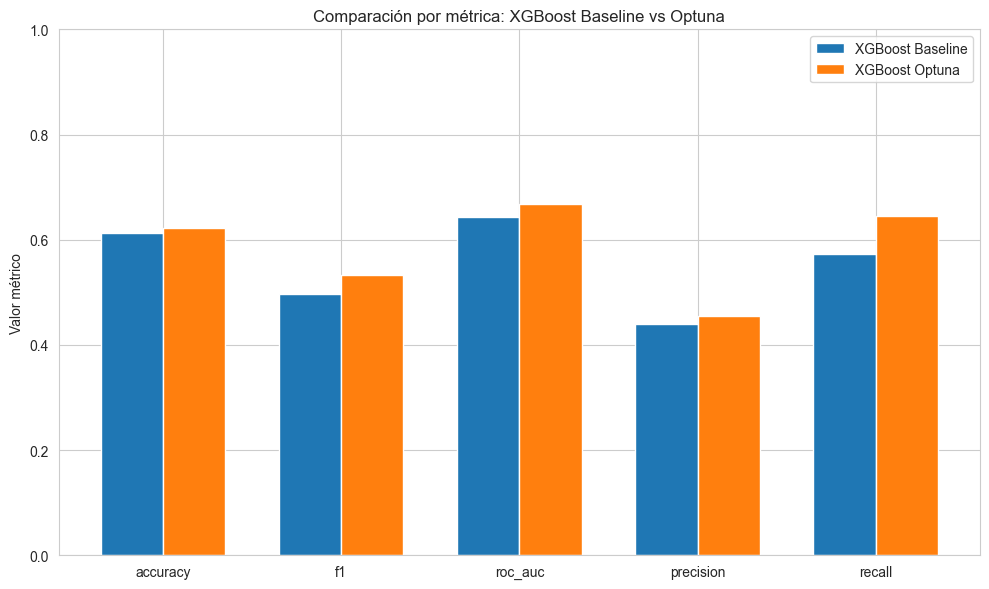

In [28]:
metrics = list(xgb_results.keys())
baseline = [xgb_results[m] for m in metrics]
optuna   = [optuna_results[m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, baseline, width, label='XGBoost Baseline')
plt.bar(x + width/2, optuna,   width, label='XGBoost Optuna')

plt.xticks(x, metrics)
plt.ylabel("Valor métrico")
plt.title("Comparación por métrica: XGBoost Baseline vs Optuna")
plt.legend()

# 👉 Aquí configuras los saltos del eje Y
plt.yticks(np.arange(0, 1.1, 0.2))  # desde 0 hasta 1, saltos de 0.2

plt.tight_layout()
plt.show()